<a href="https://colab.research.google.com/github/yzihan/Generative-AI/blob/main/AnimationPreview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AnimationPreview by [@pharmapsychotic](https://twitter.com/pharmapsychotic) 

This notebook lets you preview camera motion animations for [Disco Diffusion](https://colab.research.google.com/github/alembics/disco-diffusion/blob/main/Disco_Diffusion.ipynb), [2D Animation enabled JAX](https://colab.research.google.com/drive/1nmtcbQsE8sTjfLJ1u3Y4d6vi9ZTAvQph?usp=sharing), and [Deforum Stable Diffusion](https://colab.research.google.com/github/deforum/stable-diffusion/blob/main/Deforum_Stable_Diffusion.ipynb)

Get a preview of what your camera transforms will look like in a couple minutes instead of hours waiting on a full Disco animation to render. 

For help creating your key frames check out:
* [Keyframe string generator for AI animation notebooks](https://www.chigozie.co.uk/keyframe-string-generator/) by [chigozienri](https://twitter.com/chigozienri)
* [Audio keyframe generator](https://www.chigozie.co.uk/audio-keyframe-generator/) by [chigozienri](https://twitter.com/chigozienri)
* [Wiggle 5.1](https://colab.research.google.com/github/zippy731/wiggle/blob/main/Wiggle_Standalone_5_1.ipynb) random camera animation notebook by [zippy731](https://twitter.com/zippy731)
* For convenience a version of Wiggle 5.1 that you can quickly copy/paste generated key frames is included below!

<br>

2022/08/31:
* Updated to latest Wiggle 5.1 with looping!

2022/08/25:
* Added new generator using Perlin noise
* Plot the random values and Perlin noise values

2022/08/16:
* Added support for initial image
* Added parameters to control the preview (how much darkening per frame and rect frame interval)
* Optimizations

<br>

If you're looking for more Ai art tools check out my [Ai generative art tools list](https://pharmapsychotic.com/tools.html).


In [1]:
#@title Check GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-3dd765bd-8791-fd37-de2f-afd4622dbd23)


In [2]:
#@title Install libraries
!git clone https://github.com/alembics/disco-diffusion.git
!git clone https://github.com/shariqfarooq123/AdaBins.git
!git clone https://github.com/isl-org/MiDaS.git
!git clone https://github.com/MSFTserver/pytorch3d-lite.git
!pip install perlin_noise timm tqdm

import os
import shutil
import subprocess
import sys
sys.path.insert(0, os.path.join(os.getcwd(), 'disco-diffusion'))
sys.path.append(os.path.join(os.getcwd(), 'pytorch3d-lite'))
sys.path.append(os.path.join(os.getcwd(), 'AdaBins'))
sys.path.append(os.path.join(os.getcwd(), 'MiDaS'))

model_path = '.'

def wget(url, outputdir):
    res = subprocess.run(['wget', url, '-P', f'{outputdir}'], stdout=subprocess.PIPE).stdout.decode('utf-8')
    print(res)

if not os.path.exists(os.path.join(model_path, 'dpt_large-midas-2f21e586.pt')):
    wget("https://github.com/intel-isl/DPT/releases/download/1_0/dpt_large-midas-2f21e586.pt", model_path)
if not os.path.exists('MiDaS/midas_utils.py'):
    shutil.move('MiDaS/utils.py', 'MiDaS/midas_utils.py')
if not os.path.exists('./pretrained/AdaBins_nyu.pt'):
    os.makedirs('./pretrained', exist_ok=True)
    wget("https://cloudflare-ipfs.com/ipfs/Qmd2mMnDLWePKmgfS8m6ntAg4nhV5VkUyAydYBp8cWWeB7/AdaBins_nyu.pt", './pretrained')


import cv2
import io
import ipywidgets as widgets
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import requests
import torch
from base64 import b64encode
from IPython import display
from ipywidgets import Layout, Output, Text
from perlin_noise import PerlinNoise
from PIL import Image, ImageDraw, ImageOps
from torch import nn
from torch.nn import functional as F
from tqdm import tqdm
import disco_xform_utils as dxf
import py3d_tools as p3dT
import torchvision.transforms as T
import torchvision.transforms.functional as TF

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


Cloning into 'disco-diffusion'...
remote: Enumerating objects: 528, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 528 (delta 7), reused 5 (delta 2), pack-reused 513
Receiving objects: 100% (528/528), 447.22 KiB | 1.86 MiB/s, done.
Resolving deltas: 100% (315/315), done.
Cloning into 'AdaBins'...
remote: Enumerating objects: 80, done.
remote: Total 80 (delta 0), reused 0 (delta 0), pack-reused 80
Unpacking objects: 100% (80/80), done.
Cloning into 'MiDaS'...
remote: Enumerating objects: 501, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 501 (delta 69), reused 46 (delta 44), pack-reused 409
Receiving objects: 100% (501/501), 414.88 KiB | 19.76 MiB/s, done.
Resolving deltas: 100% (167/167), done.
Cloning into 'pytorch3d-lite'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (39/39)

In [3]:
#@title Setup

def fetch(url_or_path):
    if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
        r = requests.get(url_or_path)
        r.raise_for_status()
        fd = io.BytesIO()
        fd.write(r.content)
        fd.seek(0)
        return fd
    return open(url_or_path, 'rb')

def parse_key_frames(string, prompt_parser=None):
    import re
    pattern = r'((?P<frame>[0-9]+):[\s]*[\(](?P<param>[\S\s]*?)[\)])'
    frames = dict()
    for match_object in re.finditer(pattern, string):
        frame = int(match_object.groupdict()['frame'])
        param = match_object.groupdict()['param']
        if prompt_parser:
            frames[frame] = prompt_parser(param)
        else:
            frames[frame] = param

    if frames == {} and len(string) != 0:
        raise RuntimeError('Key Frame string not correctly formatted')
    return frames

def get_inbetweens(key_frames, integer=False):
    key_frame_series = pd.Series([np.nan for a in range(max_frames)])

    for i, value in key_frames.items():
        key_frame_series[i] = value
    key_frame_series = key_frame_series.astype(float)
    
    interp_method = interp_spline

    if interp_method == 'Cubic' and len(key_frames.items()) <=3:
      interp_method = 'Quadratic'
    
    if interp_method == 'Quadratic' and len(key_frames.items()) <= 2:
      interp_method = 'Linear'
      
    
    key_frame_series[0] = key_frame_series[key_frame_series.first_valid_index()]
    key_frame_series[max_frames-1] = key_frame_series[key_frame_series.last_valid_index()]
    # key_frame_series = key_frame_series.interpolate(method=intrp_method,order=1, limit_direction='both')
    key_frame_series = key_frame_series.interpolate(method=interp_method.lower(),limit_direction='both')
    if integer:
        return key_frame_series.astype(int)
    return key_frame_series

TRANSLATION_SCALE = 1.0/200.0

def do_3d_step(img_filepath, frame_num, midas_model, midas_transform):
    translation_x = translation_x_series[frame_num]
    translation_y = translation_y_series[frame_num]
    translation_z = translation_z_series[frame_num]
    rotation_3d_x = rotation_3d_x_series[frame_num]
    rotation_3d_y = rotation_3d_y_series[frame_num]
    rotation_3d_z = rotation_3d_z_series[frame_num]
    translate_xyz = [-translation_x*TRANSLATION_SCALE, translation_y*TRANSLATION_SCALE, -translation_z*TRANSLATION_SCALE]
    rotate_xyz_degrees = [rotation_3d_x, rotation_3d_y, rotation_3d_z]
    rotate_xyz = [math.radians(rotate_xyz_degrees[0]), math.radians(rotate_xyz_degrees[1]), math.radians(rotate_xyz_degrees[2])]
    rot_mat = p3dT.euler_angles_to_matrix(torch.tensor(rotate_xyz, device=device), "XYZ").unsqueeze(0)
    next_step_pil = transform_image_3d(img_filepath, midas_model, midas_transform, device,
                                            rot_mat, translate_xyz, near_plane, far_plane,
                                            fov, padding_mode=padding_mode,
                                            sampling_mode=sampling_mode, midas_weight=midas_weight)
    return next_step_pil


# Load MiDaS model
from midas.dpt_depth import DPTDepthModel
from midas.midas_net import MidasNet
from midas.midas_net_custom import MidasNet_small
from midas.transforms import Resize, NormalizeImage, PrepareForNet

# Initialize MiDaS depth model.
# It remains resident in VRAM and likely takes around 2GB VRAM.
# You could instead initialize it for each frame (and free it after each frame) to save VRAM.. but initializing it is slow.
default_models = {
    #"midas_v21_small": f"{model_path}/model-small-70d6b9c8.pt",
    #"midas_v21": f"{model_path}/midas_v21-f6b98070.pt",
    "dpt_large": f"{model_path}/dpt_large-midas-2f21e586.pt",
    #"dpt_hybrid": f"{model_path}/dpt_hybrid-midas-501f0c75.pt",
    #"dpt_hybrid_nyu": f"{model_path}/dpt_hybrid_nyu-2ce69ec7.pt",
}

def init_midas_depth_model(midas_model_type="dpt_large", optimize=True):
    midas_model = None
    net_w = None
    net_h = None
    resize_mode = None
    normalization = None

    print(f"Initializing MiDaS '{midas_model_type}' depth model...")
    # load network
    midas_model_path = default_models[midas_model_type]

    if midas_model_type == "dpt_large": # DPT-Large
        midas_model = DPTDepthModel(
            path=midas_model_path,
            backbone="vitl16_384",
            non_negative=True,
        )
        net_w, net_h = 384, 384
        resize_mode = "minimal"
        normalization = NormalizeImage(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    elif midas_model_type == "dpt_hybrid": #DPT-Hybrid
        midas_model = DPTDepthModel(
            path=midas_model_path,
            backbone="vitb_rn50_384",
            non_negative=True,
        )
        net_w, net_h = 384, 384
        resize_mode="minimal"
        normalization = NormalizeImage(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    elif midas_model_type == "dpt_hybrid_nyu": #DPT-Hybrid-NYU
        midas_model = DPTDepthModel(
            path=midas_model_path,
            backbone="vitb_rn50_384",
            non_negative=True,
        )
        net_w, net_h = 384, 384
        resize_mode="minimal"
        normalization = NormalizeImage(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    elif midas_model_type == "midas_v21":
        midas_model = MidasNet(midas_model_path, non_negative=True)
        net_w, net_h = 384, 384
        resize_mode="upper_bound"
        normalization = NormalizeImage(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        )
    elif midas_model_type == "midas_v21_small":
        midas_model = MidasNet_small(midas_model_path, features=64, backbone="efficientnet_lite3", exportable=True, non_negative=True, blocks={'expand': True})
        net_w, net_h = 256, 256
        resize_mode="upper_bound"
        normalization = NormalizeImage(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        )
    else:
        print(f"midas_model_type '{midas_model_type}' not implemented")
        assert False

    midas_transform = T.Compose(
        [
            Resize(
                net_w,
                net_h,
                resize_target=None,
                keep_aspect_ratio=True,
                ensure_multiple_of=32,
                resize_method=resize_mode,
                image_interpolation_method=cv2.INTER_CUBIC,
            ),
            normalization,
            PrepareForNet(),
        ]
    )

    midas_model.eval()
    
    if optimize==True:
        if device == torch.device("cuda"):
            midas_model = midas_model.to(memory_format=torch.channels_last)  
            midas_model = midas_model.half()

    midas_model.to(device)

    print(f"MiDaS '{midas_model_type}' depth model initialized.")
    return midas_model, midas_transform, net_w, net_h, resize_mode, normalization


# ======== modified disco_xform_utils ========
import torch, torchvision
import py3d_tools as p3d
import midas_utils
from PIL import Image
import numpy as np
import sys, math

try:
    from infer import InferenceHelper
except:
    print("disco_xform_utils.py failed to import InferenceHelper. Please ensure that AdaBins directory is in the path (i.e. via sys.path.append('./AdaBins') or other means).")
    sys.exit()

MAX_ADABINS_AREA = 500000
MIN_ADABINS_AREA = 448*448

@torch.no_grad()
def transform_image_3d(img_filepath, midas_model, midas_transform, device, rot_mat=torch.eye(3).unsqueeze(0), translate=(0.,0.,-0.04), near=2000, far=20000, fov_deg=60, padding_mode='border', sampling_mode='bicubic', midas_weight = 0.3,spherical=False):
    img_pil = to_pil_image(img_filepath)
    w, h = img_pil.size
    image_tensor = torchvision.transforms.functional.to_tensor(img_pil).to(device)

    use_adabins = midas_weight < 1.0 and use_depth_warping

    if use_adabins:
        # AdaBins
        """
        predictions using nyu dataset
        """
        #print("Running AdaBins depth estimation implementation...")
        infer_helper = InferenceHelper(dataset='nyu', device=device)

        image_pil_area = w*h
        if image_pil_area > MAX_ADABINS_AREA:
            scale = math.sqrt(MAX_ADABINS_AREA) / math.sqrt(image_pil_area)
            depth_input = img_pil.resize((int(w*scale), int(h*scale)), Image.LANCZOS) # LANCZOS is supposed to be good for downsampling.
        elif image_pil_area < MIN_ADABINS_AREA:
            scale = math.sqrt(MIN_ADABINS_AREA) / math.sqrt(image_pil_area)
            depth_input = img_pil.resize((int(w*scale), int(h*scale)), Image.BICUBIC)
        else:
            depth_input = img_pil
        try:
            _, adabins_depth = infer_helper.predict_pil(depth_input)
            if image_pil_area != MAX_ADABINS_AREA:
                adabins_depth = torchvision.transforms.functional.resize(torch.from_numpy(adabins_depth), image_tensor.shape[-2:], interpolation=torchvision.transforms.functional.InterpolationMode.BICUBIC).squeeze().to(device)
            else:
                adabins_depth = torch.from_numpy(adabins_depth).squeeze().to(device)
            adabins_depth_np = adabins_depth.cpu().numpy()
        except:
            pass

    torch.cuda.empty_cache()

    # MiDaS

    # MiDaS depth estimation implementation
    if midas_model and use_depth_warping:
        if not isinstance(img_filepath, str):
            to_pil_image(img_filepath).save('midas_input.png')
            img_filepath = 'midas_input.png'
        img_midas = midas_utils.read_image(img_filepath)
        img_midas_input = midas_transform({"image": img_midas})["image"]
        midas_optimize = True

        #print("Running MiDaS depth estimation implementation...")
        sample = torch.from_numpy(img_midas_input).float().to(device).unsqueeze(0)
        if midas_optimize==True and device == torch.device("cuda"):
            sample = sample.to(memory_format=torch.channels_last)  
            sample = sample.half()
        prediction_torch = midas_model.forward(sample)
        prediction_torch = torch.nn.functional.interpolate(
                prediction_torch.unsqueeze(1),
                size=img_midas.shape[:2],
                mode="bicubic",
                align_corners=False,
            ).squeeze()
    else:
        prediction_torch = torch.zeros((1, h, w), device=device) 
    prediction_np = prediction_torch.clone().cpu().numpy()

    #print("Finished depth estimation.")
    torch.cuda.empty_cache()

    # MiDaS makes the near values greater, and the far values lesser. Let's reverse that and try to align with AdaBins a bit better.
    prediction_np = np.subtract(50.0, prediction_np)
    prediction_np = prediction_np / 19.0

    if use_adabins:
        adabins_weight = 1.0 - midas_weight
        depth_map = prediction_np*midas_weight + adabins_depth_np*adabins_weight
    else:
        depth_map = prediction_np

    depth_map = np.expand_dims(depth_map, axis=0)
    depth_tensor = torch.from_numpy(depth_map).squeeze().to(device)

    pixel_aspect = 1.0 # really.. the aspect of an individual pixel! (so usually 1.0)
    persp_cam_old = p3d.FoVPerspectiveCameras(near, far, pixel_aspect, fov=fov_deg, degrees=True, device=device)
    persp_cam_new = p3d.FoVPerspectiveCameras(near, far, pixel_aspect, fov=fov_deg, degrees=True, R=rot_mat, T=torch.tensor([translate]), device=device)

    # range of [-1,1] is important to torch grid_sample's padding handling
    y,x = torch.meshgrid(torch.linspace(-1.,1.,h,dtype=torch.float32,device=device),torch.linspace(-1.,1.,w,dtype=torch.float32,device=device))
    z = torch.as_tensor(depth_tensor, dtype=torch.float32, device=device)
    xyz_old_world = torch.stack((x.flatten(), y.flatten(), z.flatten()), dim=1)

    # Transform the points using pytorch3d. With current functionality, this is overkill and prevents it from working on Windows.
    # If you want it to run on Windows (without pytorch3d), then the transforms (and/or perspective if that's separate) can be done pretty easily without it.
    xyz_old_cam_xy = persp_cam_old.get_full_projection_transform().transform_points(xyz_old_world)[:,0:2]
    xyz_new_cam_xy = persp_cam_new.get_full_projection_transform().transform_points(xyz_old_world)[:,0:2]

    offset_xy = xyz_new_cam_xy - xyz_old_cam_xy
    # affine_grid theta param expects a batch of 2D mats. Each is 2x3 to do rotation+translation.
    identity_2d_batch = torch.tensor([[1.,0.,0.],[0.,1.,0.]], device=device).unsqueeze(0)
    # coords_2d will have shape (N,H,W,2).. which is also what grid_sample needs.
    coords_2d = torch.nn.functional.affine_grid(identity_2d_batch, [1,1,h,w], align_corners=False)
    offset_coords_2d = coords_2d - torch.reshape(offset_xy, (h,w,2)).unsqueeze(0)

    if spherical:
        spherical_grid = get_spherical_projection(h, w, torch.tensor([0,0], device=device), -0.4,device=device)#align_corners=False
        stage_image = torch.nn.functional.grid_sample(image_tensor.add(1/512 - 0.0001).unsqueeze(0), offset_coords_2d, mode=sampling_mode, padding_mode=padding_mode, align_corners=True)
        new_image = torch.nn.functional.grid_sample(stage_image, spherical_grid,align_corners=True) #, mode=sampling_mode, padding_mode=padding_mode, align_corners=False)
    else:
        new_image = torch.nn.functional.grid_sample(image_tensor.add(1/512 - 0.0001).unsqueeze(0), offset_coords_2d, mode=sampling_mode, padding_mode=padding_mode, align_corners=False)

    img_pil = torchvision.transforms.ToPILImage()(new_image.squeeze().clamp(0,1.))

    torch.cuda.empty_cache()

    return img_pil

def get_spherical_projection(H, W, center, magnitude,device):  
    xx, yy = torch.linspace(-1, 1, W,dtype=torch.float32,device=device), torch.linspace(-1, 1, H,dtype=torch.float32,device=device)  
    gridy, gridx  = torch.meshgrid(yy, xx)
    grid = torch.stack([gridx, gridy], dim=-1)  
    d = center - grid
    d_sum = torch.sqrt((d**2).sum(axis=-1))
    grid += d * d_sum.unsqueeze(-1) * magnitude 
    return grid.unsqueeze(0)


# ======== preview rendering ========

def draw_preview(img, preview_darken, scale):
    img1 = ImageDraw.Draw(img, "RGBA")
    img1.rectangle([(0,0),(img.width,img.height)], fill=(0,0,0,int(preview_darken*255)))
    if scale > 0:
        rw = img.width * scale
        rh = img.height * scale
        x, y = (img.width-rw)/2, (img.height-rh)/2
        shape = [(x, y), (x+rw, y+rh)]
        img1.rectangle(shape, outline="white", width=2)

def to_cv2_image(img):
    if isinstance(img, np.ndarray):
        return img
    if isinstance(img, str):
        return cv2.imread(img)
    if isinstance(img, Image.Image):
        return cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    assert(0)
    return img        

def to_pil_image(img):
    if isinstance(img, Image.Image):
        return img
    if isinstance(img, str):
        return Image.open(fetch(init_image)).convert('RGB')
    if isinstance(img, np.ndarray):        
        return Image.fromarray(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    assert(0)
    return img

def do_it():
    global init_image
    prev_frame = None
    prev_frame_scaled = None
    old_frame_scaled = None

    if (animation_mode == "3D") and use_depth_warping:
        midas_model, midas_transform, midas_net_w, midas_net_h, midas_resize_mode, midas_normalization = init_midas_depth_model(midas_depth_model)
    else:
        midas_model = None
        midas_transform = None

    for frame_num in tqdm(range(0, max_frames)):
        frame_filename = f'frame_{frame_num:04d}.png'
        if use_depth_warping:
            display.clear_output(wait=True)
            print(f"Rendering frame {frame_num+1} of {max_frames}")

        if animation_mode == "2D":
            angle = angle_series[frame_num]
            zoom = zoom_series[frame_num]
            translation_x = translation_x_series[frame_num]
            translation_y = translation_y_series[frame_num]
            if frame_num > 0:
                img_0 = to_cv2_image(prev_frame)
                center = (1*img_0.shape[1]//2, 1*img_0.shape[0]//2)
                trans_mat = np.float32([[1, 0, translation_x], [0, 1, translation_y]])
                rot_mat = cv2.getRotationMatrix2D( center, angle, zoom )
                trans_mat = np.vstack([trans_mat, [0,0,1]])
                rot_mat = np.vstack([rot_mat, [0,0,1]])
                transformation_matrix = np.matmul(rot_mat, trans_mat)
                img_0 = cv2.warpPerspective(
                    img_0,
                    transformation_matrix,
                    (img_0.shape[1], img_0.shape[0]),
                    borderMode=cv2.BORDER_WRAP
                )
                prev_frame_scaled = img_0
                init_image = prev_frame_scaled
        elif animation_mode == "3D":
            if frame_num > 0:
                img_filepath = prev_frame
                next_step_pil = do_3d_step(img_filepath, frame_num, midas_model, midas_transform)                
                prev_frame_scaled = next_step_pil

                ### Turbo mode - skip some diffusions, use 3d morph for clarity and to save time
                if turbo_mode:
                    if frame_num == turbo_preroll: #start tracking oldframe
                        old_frame_scaled = next_step_pil #stash for later blending          
                    elif frame_num > turbo_preroll:
                        #set up 2 warped image sequences, old & new, to blend toward new diff image
                        old_frame = do_3d_step(old_frame_scaled, frame_num, midas_model, midas_transform)
                        old_frame_scaled = old_frame #old_frame.save('oldFrameScaled.png')                        
                        if frame_num % int(turbo_steps) != 0: 
                            #print('turbo skip this frame: skipping clip diffusion steps')
                            blend_factor = ((frame_num % int(turbo_steps))+1)/int(turbo_steps)
                            #print('turbo skip this frame: skipping clip diffusion steps and saving blended frame')
                            newWarpedImg = prev_frame_scaled
                            oldWarpedImg = old_frame_scaled
                            blendedImage = cv2.addWeighted(to_cv2_image(newWarpedImg), blend_factor, to_cv2_image(oldWarpedImg),1-blend_factor, 0.0)
                            cv2.imwrite(frame_filename, blendedImage)
                            prev_frame = next_step_pil # save it also as prev_frame to feed next iteration
                            continue
                        else:
                            #if not a skip frame, will run diffusion and need to blend.
                            oldWarpedImg = prev_frame_scaled
                            old_frame_scaled = oldWarpedImg #swap in for blending later 
                            #print('clip/diff this frame - generate clip diff image')

                init_image = prev_frame_scaled

        if init_image is None or init_image == '':
            init = Image.new("RGB", (width_height[0], width_height[1]))
        elif isinstance(init_image, str):
            init = Image.open(fetch(init_image)).convert('RGB').resize((width_height[0], width_height[1]))
        else:
            init = to_pil_image(init_image)
        image = init

        draw_preview(image, preview_darken, 0.25 if frame_num % int(preview_rect_frame_delta) == 0 else 0)

        prev_frame = image
        if animation_mode == "2D":
            image.save(frame_filename)
        elif animation_mode == "3D":
            if turbo_mode and frame_num > 0:
                # Mix new image with prevFrameScaled
                blend_factor = (1)/int(turbo_steps)
                newFrame = prev_frame
                prev_frame_warped = prev_frame_scaled
                blendedImage = cv2.addWeighted(to_cv2_image(newFrame), blend_factor, to_cv2_image(prev_frame_warped), (1-blend_factor), 0.0)
                cv2.imwrite(frame_filename, blendedImage)
            else:
                image.save(frame_filename)

    display.clear_output(wait=True)
    print("Creating preview video...")

    # make video
    FPS = 24
    cmd = [
        'ffmpeg',
        '-y',
        '-vcodec', 'png',
        '-r', str(video_fps),
        '-start_number', str(0),
        '-i', f'frame_%04d.png',
        '-frames:v', str(max_frames),
        '-c:v', 'libx264',
        '-vf',
        f'fps={video_fps}',
        '-pix_fmt', 'yuv420p',
        '-crf', '17',
        '-preset', 'veryfast',
        'anim_preview.mp4'
    ]
    process = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    if process.returncode != 0:
        print(stderr)
        raise RuntimeError(stderr)

    # delete the frame images
    for frame_num in range(0, max_frames):
        frame_filename = f'frame_{frame_num:04d}.png'
        os.remove(frame_filename)

    display.clear_output(wait=True)


# Animation preview rendering

In [5]:
#@title Animation preview
width_height = [640, 512] #@param{type: 'raw'}
video_fps = 24 #@param {type:"number"}
animation_mode = '2D' #@param ['2D', '3D'] {type:'string'}
init_image = "/content/sample_data/visualization.jpg" #@param{type: 'string'}
preview_darken = 0.05 #@param{type: 'number'}
preview_rect_frame_delta = 5#@param{type: 'number'}

#@markdown

#@markdown #### Camera key frames
max_frames = 250#@param {type:"number"}
interp_spline = 'Linear' #Do not change, currently will not look good. param ['Linear','Quadratic','Cubic']{type:"string"}
angle = "0:(0)"#@param {type:"string"}
zoom = "0:(1.05)"#@param {type:"string"}
translation_x = "0:(-2.292),1:(-2.841),2:(-3.421),3:(-4.028),4:(-4.660),5:(-5.310),6:(-5.974),7:(-6.642),8:(-7.310),9:(-7.967),10:(-8.608),11:(-9.223),12:(-9.805),13:(-10.347),14:(-10.841),15:(-11.281),16:(-11.662),17:(-11.979),18:(-12.227),19:(-12.403),20:(-12.506),21:(-12.532),22:(-12.483),23:(-12.358),24:(-12.159),25:(-11.889),26:(-11.551),27:(-11.149),28:(-10.689),29:(-10.175),30:(-9.615),31:(-9.014),32:(-8.380),33:(-7.720),34:(-7.042),35:(-6.353),36:(-5.660),37:(-4.968),38:(-4.285),39:(-3.615),40:(-2.961),41:(-2.326),42:(-1.710),43:(-1.113),44:(-0.529),45:(0.046),46:(0.620),47:(1.192),48:(1.759),49:(2.317),50:(2.863),51:(3.394),52:(3.905),53:(4.392),54:(4.851),55:(5.279),56:(5.670),57:(6.022),58:(6.332),59:(6.597),60:(6.814),61:(6.982),62:(7.099),63:(7.165),64:(7.179),65:(7.142),66:(7.054),67:(6.917),68:(6.733),69:(6.505),70:(6.236),71:(5.929),72:(5.590),73:(5.222),74:(4.831),75:(4.422),76:(4.000),77:(3.572),78:(3.144),79:(2.720),80:(2.309),81:(1.914),82:(1.542),83:(1.199),84:(0.887),85:(0.612),86:(0.377),87:(0.184),88:(0.035),89:(-0.071),90:(-0.134),91:(-0.158),92:(-0.148),93:(-0.108),94:(-0.049),95:(0.020),96:(0.094),97:(0.184),98:(0.301),99:(0.451),100:(0.640),101:(0.871),102:(1.144),103:(1.459),104:(1.814),105:(2.206),106:(2.631),107:(3.084),108:(3.560),109:(4.051),110:(4.552),111:(5.056),112:(5.556),113:(6.045),114:(6.516),115:(6.964),116:(7.382),117:(7.764),118:(8.105),119:(8.400),120:(8.646),121:(8.840),122:(8.977),123:(9.057),124:(9.078),125:(9.040),126:(8.942),127:(8.785),128:(8.571),129:(8.303),130:(7.982),131:(7.612),132:(7.198),133:(6.742),134:(6.250),135:(5.726),136:(5.175),137:(4.601),138:(4.011),139:(3.408),140:(2.796),141:(2.179),142:(1.559),143:(0.940),144:(0.321),145:(-0.297),146:(-0.917),147:(-1.538),148:(-2.162),149:(-2.787),150:(-3.409),151:(-4.027),152:(-4.636),153:(-5.231),154:(-5.807),155:(-6.360),156:(-6.885),157:(-7.375),158:(-7.827),159:(-8.235),160:(-8.596),161:(-8.905),162:(-9.160),163:(-9.357),164:(-9.495),165:(-9.571),166:(-9.586),167:(-9.540),168:(-9.433),169:(-9.267),170:(-9.044),171:(-8.768),172:(-8.442),173:(-8.071),174:(-7.659),175:(-7.212),176:(-6.737),177:(-6.239),178:(-5.726),179:(-5.204),180:(-4.680),181:(-4.162),182:(-3.655),183:(-3.168),184:(-2.704),185:(-2.271),186:(-1.872),187:(-1.511),188:(-1.191),189:(-0.911),190:(-0.672),191:(-0.471),192:(-0.304),193:(-0.163),194:(-0.038),195:(0.081),196:(0.196),197:(0.301),198:(0.393),199:(0.467),200:(0.521),201:(0.554),202:(0.564),203:(0.550),204:(0.512),205:(0.452),206:(0.369),207:(0.264),208:(0.141),209:(-0.000),210:(-0.156),211:(-0.325),212:(-0.505),213:(-0.693),214:(-0.885),215:(-1.080),216:(-1.274),217:(-1.466),218:(-1.651),219:(-1.829),220:(-1.995),221:(-2.149),222:(-2.287),223:(-2.408),224:(-2.510),225:(-2.592),226:(-2.652),227:(-2.689),228:(-2.702),229:(-2.692),230:(-2.656),231:(-2.596),232:(-2.512),233:(-2.404),234:(-2.273),235:(-2.120),236:(-1.946),237:(-1.753),238:(-1.542),239:(-1.316),240:(-1.076),241:(-0.825),242:(-0.566),243:(-0.300),244:(-0.032),245:(0.238),246:(0.513),247:(0.799),248:(1.098),249:(1.412)"#@param {type:"string"}
translation_y = "0:(-12.694),1:(-13.340),2:(-13.920),3:(-14.428),4:(-14.858),5:(-15.204),6:(-15.461),7:(-15.626),8:(-15.698),9:(-15.674),10:(-15.556),11:(-15.345),12:(-15.044),13:(-14.657),14:(-14.188),15:(-13.643),16:(-13.030),17:(-12.357),18:(-11.631),19:(-10.862),20:(-10.059),21:(-9.232),22:(-8.390),23:(-7.543),24:(-6.699),25:(-5.867),26:(-5.055),27:(-4.267),28:(-3.508),29:(-2.782),30:(-2.087),31:(-1.423),32:(-0.783),33:(-0.159),34:(0.460),35:(1.078),36:(1.693),37:(2.303),38:(2.904),39:(3.491),40:(4.062),41:(4.611),42:(5.134),43:(5.627),44:(6.086),45:(6.505),46:(6.882),47:(7.213),48:(7.495),49:(7.724),50:(7.900),51:(8.021),52:(8.085),53:(8.092),54:(8.044),55:(7.940),56:(7.783),57:(7.575),58:(7.318),59:(7.018),60:(6.676),61:(6.299),62:(5.891),63:(5.459),64:(5.007),65:(4.542),66:(4.071),67:(3.601),68:(3.136),69:(2.685),70:(2.254),71:(1.847),72:(1.472),73:(1.131),74:(0.831),75:(0.573),76:(0.361),77:(0.194),78:(0.072),79:(-0.006),80:(-0.046),81:(-0.052),82:(-0.034),83:(-0.002),84:(0.035),85:(0.081),86:(0.146),87:(0.235),88:(0.353),89:(0.504),90:(0.689),91:(0.907),92:(1.158),93:(1.440),94:(1.750),95:(2.084),96:(2.438),97:(2.809),98:(3.190),99:(3.576),100:(3.963),101:(4.345),102:(4.717),103:(5.073),104:(5.410),105:(5.722),106:(6.004),107:(6.255),108:(6.468),109:(6.643),110:(6.776),111:(6.866),112:(6.910),113:(6.910),114:(6.863),115:(6.770),116:(6.633),117:(6.452),118:(6.229),119:(5.967),120:(5.668),121:(5.334),122:(4.971),123:(4.580),124:(4.165),125:(3.730),126:(3.280),127:(2.816),128:(2.344),129:(1.865),130:(1.383),131:(0.899),132:(0.415),133:(-0.069),134:(-0.554),135:(-1.045),136:(-1.545),137:(-2.055),138:(-2.574),139:(-3.102),140:(-3.636),141:(-4.172),142:(-4.707),143:(-5.236),144:(-5.754),145:(-6.256),146:(-6.736),147:(-7.189),148:(-7.611),149:(-7.995),150:(-8.339),151:(-8.637),152:(-8.887),153:(-9.084),154:(-9.227),155:(-9.315),156:(-9.345),157:(-9.319),158:(-9.235),159:(-9.096),160:(-8.903),161:(-8.659),162:(-8.368),163:(-8.032),164:(-7.656),165:(-7.246),166:(-6.807),167:(-6.344),168:(-5.864),169:(-5.372),170:(-4.875),171:(-4.379),172:(-3.890),173:(-3.413),174:(-2.953),175:(-2.515),176:(-2.101),177:(-1.715),178:(-1.357),179:(-1.026),180:(-0.722),181:(-0.439),182:(-0.171),183:(0.089),184:(0.345),185:(0.587),186:(0.808),187:(1.000),188:(1.158),189:(1.278),190:(1.358),191:(1.395),192:(1.389),193:(1.340),194:(1.249),195:(1.117),196:(0.946),197:(0.740),198:(0.502),199:(0.236),200:(-0.055),201:(-0.366),202:(-0.691),203:(-1.028),204:(-1.371),205:(-1.714),206:(-2.054),207:(-2.385),208:(-2.703),209:(-3.004),210:(-3.283),211:(-3.537),212:(-3.762),213:(-3.954),214:(-4.111),215:(-4.230),216:(-4.308),217:(-4.345),218:(-4.339),219:(-4.290),220:(-4.196),221:(-4.058),222:(-3.877),223:(-3.655),224:(-3.392),225:(-3.091),226:(-2.755),227:(-2.386),228:(-1.990),229:(-1.570),230:(-1.130),231:(-0.676),232:(-0.213),233:(0.253),234:(0.720),235:(1.189),236:(1.660),237:(2.131),238:(2.601),239:(3.068),240:(3.527),241:(3.977),242:(4.413),243:(4.831),244:(5.228),245:(5.599),246:(5.941),247:(6.250),248:(6.523),249:(6.757)"#@param {type:"string"}
translation_z = "0:(0)"#@param {type:"string"}
rotation_3d_x = "0:(0)"#@param {type:"string"}
rotation_3d_y = "0:(0)"#@param {type:"string"}
rotation_3d_z = "0:(1)"#@param {type:"string"}


cam_code = ""#@param {type:"string"}

#@markdown

#@markdown #### Depth Warping
use_depth_warping = False #@param {type:"boolean"}
midas_depth_model = "dpt_large"
midas_weight = 0.3#@param {type:"number"}
near_plane = 200#@param {type:"number"}
far_plane = 10000#@param {type:"number"}
fov = 40#@param {type:"number"}
padding_mode = 'border'#@param {type:"string"}
sampling_mode = 'bicubic'#@param {type:"string"}

#@markdown

#@markdown #### Turbo
turbo_mode = False #@param {type:"boolean"}
turbo_steps = "3" #@param ["2","3","4","5","6"] {type:"string"}
turbo_preroll = 10 # frames
if turbo_mode and animation_mode != '3D':
    print('=====')
    print('Turbo mode only available with 3D animations. Disabling Turbo.')
    print('=====')
    turbo_mode = False

if len(cam_code):
    exec(cam_code)


try:
    angle_series = get_inbetweens(parse_key_frames(angle))
except RuntimeError as e:
    print(
        "WARNING: You have selected to use key frames, but you have not "
        "formatted `angle` correctly for key frames.\n"
        "Attempting to interpret `angle` as "
        f'"0: ({angle})"\n'
        "Please read the instructions to find out how to use key frames "
        "correctly.\n"
    )
    angle = f"0: ({angle})"
    angle_series = get_inbetweens(parse_key_frames(angle))

try:
    zoom_series = get_inbetweens(parse_key_frames(zoom))
except RuntimeError as e:
    print(
        "WARNING: You have selected to use key frames, but you have not "
        "formatted `zoom` correctly for key frames.\n"
        "Attempting to interpret `zoom` as "
        f'"0: ({zoom})"\n'
        "Please read the instructions to find out how to use key frames "
        "correctly.\n"
    )
    zoom = f"0: ({zoom})"
    zoom_series = get_inbetweens(parse_key_frames(zoom))

try:
    translation_x_series = get_inbetweens(parse_key_frames(translation_x))
except RuntimeError as e:
    print(
        "WARNING: You have selected to use key frames, but you have not "
        "formatted `translation_x` correctly for key frames.\n"
        "Attempting to interpret `translation_x` as "
        f'"0: ({translation_x})"\n'
        "Please read the instructions to find out how to use key frames "
        "correctly.\n"
    )
    translation_x = f"0: ({translation_x})"
    translation_x_series = get_inbetweens(parse_key_frames(translation_x))

try:
    translation_y_series = get_inbetweens(parse_key_frames(translation_y))
except RuntimeError as e:
    print(
        "WARNING: You have selected to use key frames, but you have not "
        "formatted `translation_y` correctly for key frames.\n"
        "Attempting to interpret `translation_y` as "
        f'"0: ({translation_y})"\n'
        "Please read the instructions to find out how to use key frames "
        "correctly.\n"
    )
    translation_y = f"0: ({translation_y})"
    translation_y_series = get_inbetweens(parse_key_frames(translation_y))

try:
    translation_z_series = get_inbetweens(parse_key_frames(translation_z))
except RuntimeError as e:
    print(
        "WARNING: You have selected to use key frames, but you have not "
        "formatted `translation_z` correctly for key frames.\n"
        "Attempting to interpret `translation_z` as "
        f'"0: ({translation_z})"\n'
        "Please read the instructions to find out how to use key frames "
        "correctly.\n"
    )
    translation_z = f"0: ({translation_z})"
    translation_z_series = get_inbetweens(parse_key_frames(translation_z))

try:
    rotation_3d_x_series = get_inbetweens(parse_key_frames(rotation_3d_x))
except RuntimeError as e:
    print(
        "WARNING: You have selected to use key frames, but you have not "
        "formatted `rotation_3d_x` correctly for key frames.\n"
        "Attempting to interpret `rotation_3d_x` as "
        f'"0: ({rotation_3d_x})"\n'
        "Please read the instructions to find out how to use key frames "
        "correctly.\n"
    )
    rotation_3d_x = f"0: ({rotation_3d_x})"
    rotation_3d_x_series = get_inbetweens(parse_key_frames(rotation_3d_x))

try:
    rotation_3d_y_series = get_inbetweens(parse_key_frames(rotation_3d_y))
except RuntimeError as e:
    print(
        "WARNING: You have selected to use key frames, but you have not "
        "formatted `rotation_3d_y` correctly for key frames.\n"
        "Attempting to interpret `rotation_3d_y` as "
        f'"0: ({rotation_3d_y})"\n'
        "Please read the instructions to find out how to use key frames "
        "correctly.\n"
    )
    rotation_3d_y = f"0: ({rotation_3d_y})"
    rotation_3d_y_series = get_inbetweens(parse_key_frames(rotation_3d_y))

try:
    rotation_3d_z_series = get_inbetweens(parse_key_frames(rotation_3d_z))
except RuntimeError as e:
    print(
        "WARNING: You have selected to use key frames, but you have not "
        "formatted `rotation_3d_z` correctly for key frames.\n"
        "Attempting to interpret `rotation_3d_z` as "
        f'"0: ({rotation_3d_z})"\n'
        "Please read the instructions to find out how to use key frames "
        "correctly.\n"
    )
    rotation_3d_z = f"0: ({rotation_3d_z})"
    rotation_3d_z_series = get_inbetweens(parse_key_frames(rotation_3d_z))    

if preview_rect_frame_delta < 1:
    preview_rect_frame_delta = 1

do_it()

mp4 = open('anim_preview.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
display.display( display.HTML(f'<video controls loop><source src="{data_url}" type="video/mp4"></video>') )


<hr>

# Animation Generators


# Random keys

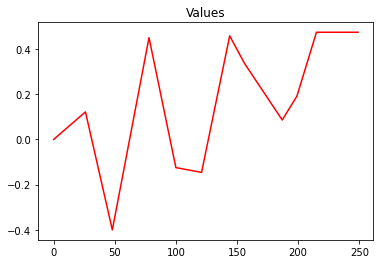

In [6]:
#@markdown ---
#@markdown Generate a random series of key frames<br>
#@markdown Every `frame_delta` frames a random value between `min_value` and `max_value` is used.<br>
#@markdown You can paste the resulting string into any of the camera attributes above
max_frames = 250 #@param {type:"integer"}
frame_delta = 24 #@param {type:"integer"}
frame_delta_variance = 0.5 #@param {type:"number"}
min_value = -.5 #@param {type:"number"}
max_value = .5 #@param {type:"number"}

import math
import random

frame = 0
value = 0
values = []
key_str = ""
while frame < max_frames:
    key_str += f"{frame}:({value:0.3f}),"
    frame += int(frame_delta + frame_delta_variance * (random.random()*2.0-1.0) * frame_delta)
    value = min_value + (max_value - min_value) * random.random()
    values.append(value)
key_str = key_str[0:-1] # remove trailing ,

values = get_inbetweens(parse_key_frames(key_str))

# show plot of the value over time
figure, axis = plt.subplots(1, 1)
axis.set_title("Values")
axis.plot([f for f in range(len(values))], values, color='r', label='x')
plt.show()

# easy control for copy/pasting
layout = Layout(width='75%')
value_widget = Text(value=key_str, description='values:', layout=layout)
widgets.VBox([value_widget])


# Perlin noise

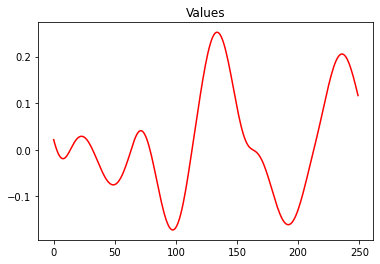

In [7]:
max_frames = 250 #@param {type:"integer"}
octaves = 1 #@param {type:"integer"}
freq_scale = 5 #@param {type:"number"}
min_value = -.5 #@param {type:"number"}
max_value = .5 #@param {type:"number"}

amplitude = max_value - min_value
mean = (max_value + min_value) / 2

noise = PerlinNoise(octaves=octaves)

key_str = ""
values = []
phase = random.random()
for frame, t in enumerate(np.linspace(0, 1, max_frames)):
    value = mean + amplitude * noise(t*freq_scale + phase)
    key_str += f"{frame}:({value:0.3f}),"
    values.append(value)
key_str = key_str[0:-1] # remove trailing ,

# show plot of the value over time
xs = [f for f in range(max_frames)]
figure, axis = plt.subplots(1, 1)
axis.set_title("Values")
axis.plot(xs, values, color='r', label='x')
plt.show()

# easy control for copy/pasting
layout = Layout(width='75%')
value_widget = Text(value=key_str, description='values:', layout=layout)
widgets.VBox([value_widget])


# [Wiggle 5.1](https://colab.research.google.com/github/zippy731/wiggle/blob/main/Wiggle_Standalone_5_1.ipynb) by [zippy731](https://twitter.com/zippy731)

In [9]:
#======= WIGGLE MODE
#@markdown ---
#@markdown ####**Wiggle:**
#@markdown Generates semirandom keyframes for zoom / spin / translation. 
#@markdown Set ranges below, then run this cell.
#@markdown

#.. can be embedded directly into DD5 notebook.  Copy this code into 
#animation settings tab, just before 'Coherency Settings'
#Then comment out standalone-only code and uncomment 'embedded-only' section.

#standalone-only:
import random
wiggle_frames = 1000#@param {type:"number"}
max_frames = wiggle_frames
#end standalone-only

#embedded-only:
use_wiggle = True #@param {type:"boolean"} 
wiggle_show_params = True #@param {type:"boolean"} 
#end embedded-only code

#@markdown Wiggle preroll and episodes (frames) and duration variability:
preroll_frames = 16#@param {type:"integer"}
episode_duration = 48#@param {type:"integer"}
wig_ads_input = '0.4,0.4,0.4'#@param {type:"string"}
wig_adsmix = [float(x) for x in wig_ads_input.split(',')]
wig_time_var = 0.2#@param {type:"number"}
#@markdown Wiggle loop: force wiggle motion to restart every [n] frames. Useful for motion matching in loops.
wig_loop = False  #@param {type:"boolean"} 
wig_loop_frames = 360#@param {type:"integer"}
#@markdown Wiggle time phases (3 values, sum to 1.0):
#@markdown Zoom (2D) and trz (3D) ranges and quiet factor
wig_zoom_min_max = '0,0'#@param {type:"string"}
wig_zoom_range= [float(x) for x in wig_zoom_min_max.split(',')]
wig_trz_min_max = '6,8'#@param {type:"string"}
wig_trz_range = [int(x) for x in wig_trz_min_max.split(',')]
wig_zoom_quiet_factor =  1.0#@param {type:"number"}# wig_zoom_quiet_scale_factor//scale of zoom quiet periods, as function of above range
#@markdown angle (2D) trx,try(2D/3D) and rotx,roty,rotz (3D) ranges and quiet factor

wig_angle_min_max = '0,0'#@param {type:"string"}
wig_angle_range= [float(x) for x in wig_angle_min_max.split(',')]
wig_trx_min_max = '-2,2'#@param {type:"string"}
wig_trx_range= [float(x) for x in wig_trx_min_max.split(',')]
wig_try_min_max = '-2,2'#@param {type:"string"}
wig_try_range= [float(x) for x in wig_try_min_max.split(',')]

wig_rotx_min_max = '-.5,.5'#@param {type:"string"}
wig_rotx_range= [float(x) for x in wig_rotx_min_max.split(',')]
wig_roty_min_max = '-.5,.5'#@param {type:"string"}
wig_roty_range= [float(x) for x in wig_roty_min_max.split(',')]
wig_rotz_min_max = '-.5,.5'#@param {type:"string"}
wig_rotz_range= [float(x) for x in wig_rotz_min_max.split(',')]
wig_motion_quiet_factor=.5 #@param {type:"number"}
#@markdown GLIDE MODE: tr_x and tr_y yoked to rot_z and rot_x, respectively.
#@markdown *ADDS* to tr_x and tr_y values set above.
# ht @BrokenMindset!
##wig_glide_mode = True #@param {type:"boolean"} 
wig_glide_x_factor = 0 #@param {type:"number"}
wig_glide_y_factor =  0#@param {type:"number"}




if use_wiggle:
    #calculate wiggle keyframes, inject into diffusion notebook  

    #calc time ranges   
    episode_count = round((max_frames)/(episode_duration*.8),0)
    wig_attack_range=(round(episode_duration*wig_adsmix[0]*(1-wig_time_var),0),round(episode_duration*wig_adsmix[0]*(1+wig_time_var),0))
    wig_decay_range=(round(episode_duration*wig_adsmix[1]*(1-wig_time_var),0),round(episode_duration*wig_adsmix[1]*(1+wig_time_var),0))
    wig_sustain_range=(round(episode_duration*wig_adsmix[2]*(1-wig_time_var),0),round(episode_duration*wig_adsmix[2]*(1+wig_time_var),0))
    #------------

    episodes = [(0,1.0,0,0,0,0,0,0,0)] #initialize episodes list
    #ep is: (frame,zoom,angle,trx,try,trz,rotx,roty,rotz)
    episode_starts = [0]
    episode_peaks = [0]
    i = 1
    skip_1 = 0
    wig_frame_count = round(preroll_frames,0)
    while i < episode_count:
      #attack: quick ramp to motion
      if wig_time_var == 0:
        skip_1 = wig_attack_range[0]
      else:
        skip_1 = round(random.randrange(wig_attack_range[0],wig_attack_range[1]),0)
      wig_frame_count += int(skip_1)
      zoom_1 = 1+round(random.uniform(wig_zoom_range[0],wig_zoom_range[1]),3)
      trz_1 = round(random.uniform(wig_trz_range[0],wig_trz_range[1]),3)
      angle_1 = round(random.uniform(wig_angle_range[0],wig_angle_range[1]),3)
      rotx_1 = round(random.uniform(wig_rotx_range[0],wig_rotx_range[1]),3) 
      roty_1 = round(random.uniform(wig_roty_range[0],wig_roty_range[1]),3) 
      rotz_1 = round(random.uniform(wig_rotz_range[0],wig_rotz_range[1]),3) 
      trx_1 = round(random.uniform(wig_trx_range[0],wig_trx_range[1]),3)+round((rotz_1*wig_glide_x_factor),3)
      try_1 = round(random.uniform(wig_try_range[0],wig_try_range[1]),3)+round((rotx_1*wig_glide_y_factor),3)


      episodes.append((wig_frame_count,zoom_1,angle_1,trx_1,try_1,trz_1,rotx_1,roty_1,rotz_1))
      episode_starts.append((wig_frame_count))
      #decay: ramp down to element of interest
      if wig_time_var == 0:
        skip_1 = wig_decay_range[0]
      else:
        skip_1 = round(random.randrange(wig_decay_range[0],wig_decay_range[1]),0)
      wig_frame_count += int(skip_1)
      zoom_1 = 1+(round(wig_zoom_quiet_factor*random.uniform(wig_zoom_range[0],wig_zoom_range[1]),3))
      trz_1 = round(wig_zoom_quiet_factor*random.uniform(wig_trz_range[0],wig_trz_range[1]),3)
      angle_1 = round(wig_motion_quiet_factor*random.uniform(wig_angle_range[0],wig_angle_range[1]),3)
      rotx_1 = round(wig_motion_quiet_factor*random.uniform(wig_rotx_range[0],wig_rotx_range[1]),3)
      roty_1 = round(wig_motion_quiet_factor*random.uniform(wig_roty_range[0],wig_roty_range[1]),3)
      rotz_1 = round(wig_motion_quiet_factor*random.uniform(wig_rotz_range[0],wig_rotz_range[1]),3)
      trx_1 = round(wig_motion_quiet_factor*random.uniform(wig_trx_range[0],wig_trx_range[1]),3)+round((rotz_1*wig_glide_x_factor),3)
      try_1 = round(wig_motion_quiet_factor*random.uniform(wig_try_range[0],wig_try_range[1]),3)+round((rotx_1*wig_glide_y_factor),3)
      episodes.append((wig_frame_count,zoom_1,angle_1,trx_1,try_1,trz_1,rotx_1,roty_1,rotz_1))
      episode_peaks.append((wig_frame_count))
      #sustain: pause during element of interest
      if wig_time_var == 0:
        skip_1 = wig_sustain_range[0]
      else:
        skip_1 = round(random.randrange(wig_sustain_range[0],wig_sustain_range[1]),0)
      wig_frame_count += int(skip_1)
      zoom_1 = 1+(round(wig_zoom_quiet_factor*random.uniform(wig_zoom_range[0],wig_zoom_range[1]),3))
      trz_1 = round(wig_zoom_quiet_factor*random.uniform(wig_trz_range[0],wig_trz_range[1]),3)     
      angle_1 = round(wig_motion_quiet_factor*random.uniform(wig_angle_range[0],wig_angle_range[1]),3)
      rotx_1 = round(wig_motion_quiet_factor*random.uniform(wig_rotx_range[0],wig_rotx_range[1]),3)
      roty_1 = round(wig_motion_quiet_factor*random.uniform(wig_roty_range[0],wig_roty_range[1]),3)
      rotz_1 = round(wig_motion_quiet_factor*random.uniform(wig_rotz_range[0],wig_rotz_range[1]),3)
      trx_1 = round(wig_motion_quiet_factor*random.uniform(wig_trx_range[0],wig_trx_range[1]),3)+round((rotz_1*wig_glide_x_factor),3)
      try_1 = round(wig_motion_quiet_factor*random.uniform(wig_try_range[0],wig_try_range[1]),3)+round((rotx_1*wig_glide_y_factor),3)
      episodes.append((wig_frame_count,zoom_1,angle_1,trx_1,try_1,trz_1,rotx_1,roty_1,rotz_1))
      i+=1

   
    if wig_loop==True and wig_loop_frames > (episode_duration*2):
      #rebuild episode list w repeats
      looping_episodes = [i for i in episodes if i[0] < wig_loop_frames and i[0]>0]
      wig_ep_loop = [(0,1.0,0,0,0,0,0,0,0)] 
      i=0
      while i < (int(max_frames/wig_loop_frames)+1):
        # now update episode list w new starts
        j=0
        while j < len(looping_episodes):
          old_ep = list(looping_episodes[j])
          new_ep_start = old_ep[0]+i*wig_loop_frames
          new_ep = [new_ep_start,old_ep[1],old_ep[2],old_ep[3],old_ep[4],old_ep[5],old_ep[6],old_ep[7],old_ep[8]]
          wig_ep_loop.append(new_ep)
          j+=1
        i+=1
      episodes = wig_ep_loop
      
    #trim off any episode > max_frames
    cleaned_episodes = [i for i in episodes if i[0] < max_frames]
    episodes = cleaned_episodes
    cleaned_episode_starts = [i for i in episode_starts if i < max_frames]
    episode_starts = cleaned_episode_starts
    cleaned_episode_peaks = [i for i in episode_peaks if i < max_frames]
    episode_peaks = cleaned_episode_peaks

    #build full schedule
    keyframe_frames = [item[0] for item in episodes]

    #Build keyframe strings 
    wig_zoom_string=''
    wig_angle_string=''
    wig_trx_string=''
    wig_try_string=''
    wig_trz_string=''
    wig_rotx_string=''
    wig_roty_string=''
    wig_rotz_string=''
    # iterate thru episodes, generate keyframe strings
    ### reformat as keyframe strings for testing
    i = 0
    while i < len(episodes):
      wig_zoom_string += str(int(episodes[i][0]))+':('+str(episodes[i][1])+'),'
      wig_angle_string += str(round(episodes[i][0],0))+':('+str(episodes[i][2])+'),'
      wig_trx_string += str(round(episodes[i][0],0))+':('+str(episodes[i][3])+'),'
      wig_try_string += str(round(episodes[i][0],0))+':('+str(episodes[i][4])+'),'
      wig_trz_string += str(round(episodes[i][0],0))+':('+str(episodes[i][5])+'),'
      wig_rotx_string += str(round(episodes[i][0],0))+':('+str(episodes[i][6])+'),'
      wig_roty_string += str(round(episodes[i][0],0))+':('+str(episodes[i][7])+'),'
      wig_rotz_string += str(round(episodes[i][0],0))+':('+str(episodes[i][8])+'),'
      i+=1    

    zoom = wig_zoom_string
    angle = wig_angle_string 
    translation_x = wig_trx_string
    translation_y =  wig_try_string
    translation_z =  wig_trz_string
    rotation_3d_x = wig_rotx_string
    rotation_3d_y = wig_roty_string
    rotation_3d_z = wig_rotz_string

#============= END WIGGLE

# pharmapsychotic: displaying as widgets for easier copy to clipboard action

code_str = ""
code_str += f"(zoom,angle,translation_x,translation_y,translation_z,rotation_3d_x,rotation_3d_y,rotation_3d_z) = "
code_str += f"('{zoom}','{angle}','{translation_x}','{translation_y}','{translation_z}','{rotation_3d_x}','{rotation_3d_y}','{rotation_3d_z}')"

print("\nCopy and paste the cam_code text above to preview. When you get what you like copy each of the fields into your Disco notebook.\n")

import ipywidgets as widgets
from ipywidgets import Layout, Text

layout = Layout(width='75%')

angle_widget = Text(value=angle, description='angle:', layout=layout)
zoom_widget = Text(value=zoom, description='zoom:', layout=layout)
translation_x_widget = Text(value=translation_x, description='translation_x:', layout=layout)
translation_y_widget = Text(value=translation_y, description='translation_y:', layout=layout)
translation_z_widget = Text(value=translation_z, description='translation_z:', layout=layout)
rotation_3d_x_widget = Text(value=rotation_3d_x, description='rot_3d_x:', layout=layout)
rotation_3d_y_widget = Text(value=rotation_3d_y, description='rot_3d_y:', layout=layout)
rotation_3d_z_widget = Text(value=rotation_3d_z, description='rot_3d_z:', layout=layout)


code_widget = widgets.Textarea(
    value=code_str,
    description='cam_code:',
    layout=Layout(width='75%', height='8em')
)

widgets.VBox([
    angle_widget, zoom_widget, 
    translation_x_widget, translation_y_widget, translation_z_widget,
    rotation_3d_x_widget, rotation_3d_y_widget, rotation_3d_z_widget,
    code_widget
])



Copy and paste the cam_code text above to preview. When you get what you like copy each of the fields into your Disco notebook.



<br>
<br>
<br>
<br>
<br>
<hr>

# Credits and License

This notebook uses code from Disco Diffusion to match the camera animation key frame settings, interpolation, and transformations.
https://github.com/alembics/disco-diffusion


The Wiggle 5.1 section comes from Zippy's notebook with modifications for easier copy/pasting here.
https://github.com/zippy731/wiggle

-- 

Licensed under the MIT License

Copyright (c) 2021 Katherine Crowson 

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in
all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
THE SOFTWARE.

--

MIT License

Copyright (c) 2019 Intel ISL (Intel Intelligent Systems Lab)

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

--

Licensed under the MIT License

Copyright (c) 2021 Maxwell Ingham

Copyright (c) 2022 Adam Letts 

Copyright (c) 2022 Alex Spirin

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in
all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
THE SOFTWARE.
